In [2]:
!pip install yfinance -q

     |████████████████████████████████| 5.5MB 13.5MB/s 


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
tf.test.gpu_device_name()

'/device:GPU:0'

[*********************100%***********************]  1 of 1 completed


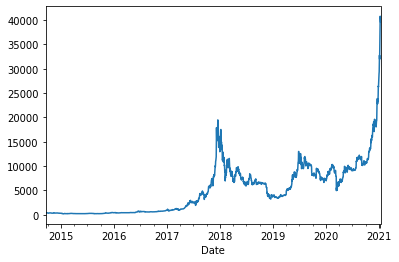

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


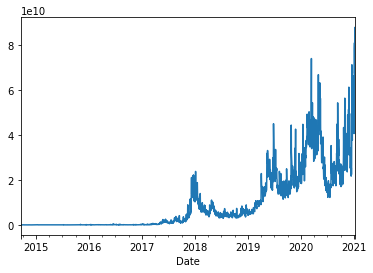

In [4]:
# Load Data
d = pd.DataFrame(yf.download("BTC-USD", start="2000-1-1", end="2021-1-10"))
d["Adj Close"].plot();
plt.show()
d["Volume"].plot();
d.head()

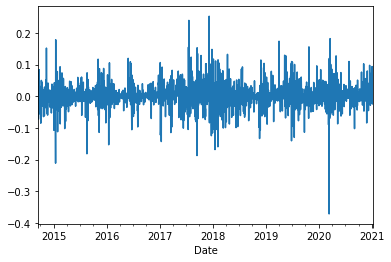

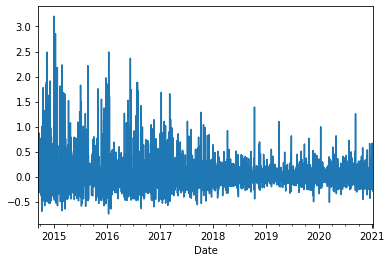

In [5]:
#get returns
df = d.pct_change().dropna()
df["Close"].plot();
plt.show()
df["Volume"].plot();

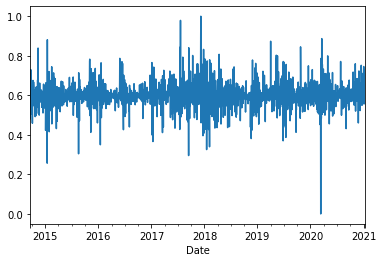

In [6]:
#normalize
retmin = min(df[["Open", "High", "Low", "Close"]].min())
retmax = max(df[["Open", "High", "Low", "Close"]].max())
norm = retmax - retmin
dfn = df.copy()

for c in df:
    if c != "Volume":
        dfn[c] = (df[c]-retmin)/norm
    else:  
        dfn[c] = (df[c]-df[c].min())/(df[c].max()-df[c].min())
    # print(dfn[c].shape)

dfn["Close"].plot();

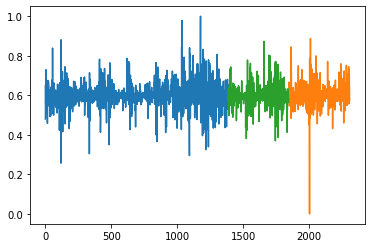

In [7]:
# split 60/20/10
dfn.reset_index(drop=True, inplace=True)
train, validate, test = np.split(dfn, [int(.6*len(dfn)), int(.8*len(dfn))])
plt.plot(train["Close"])
plt.plot(test["Close"])
plt.plot(validate["Close"])

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
seq_len=128

def Splitter(seq_len, data):
  X_data, Y_data = [], []
  for i in range(seq_len, len(data)):
    X_data.append(data[i-seq_len:i]) #Chunks of 128 len
    Y_data.append(data[:, 3][i])
  return(np.array(X_data), np.array(Y_data))



def PrepData(ticker, seq_len):
  ''' 
  Downloads and normalizes (minmax) ticker
  60/20/20 split
  2000-1-1 start
  '''

  # Load Data
  d = pd.DataFrame(yf.download(ticker, start="2000-1-1", end="2021-1-10"))
  
  # Use Adj. Close
  d["Close"] = d["Adj Close"]
  d.drop(columns=["Adj Close"], inplace=True)
  d.dropna()
  df = d.pct_change().dropna()

  #normalize
  retmin = min(df[["Open", "High", "Low", "Close"]].min())
  retmax = max(df[["Open", "High", "Low", "Close"]].max())
  norm = retmax - retmin
  dfn = df.copy()

  for c in df:
      if c != "Volume":
          dfn[c] = (df[c]-retmin)/norm
      else:  
          dfn[c] = (df[c]-df[c].min())/(df[c].max()-df[c].min())

  dfn.reset_index(drop=True, inplace=True)
  train, valid, test = (np.split(dfn, [int(.6*len(dfn)), int(.8*len(dfn))]))
  
  X_train, Y_train = Splitter(seq_len, train.values)
  X_val, Y_val = Splitter(seq_len, valid.values)
  X_test, Y_test = Splitter(seq_len, test.values)

  return (X_train, Y_train, X_val, Y_val, X_test, Y_test)

# data
X_train, Y_train, X_val, Y_val, X_test, Y_test = PrepData("BTC-USD", seq_len)

[*********************100%***********************]  1 of 1 completed


## Time2Vec
![](https://miro.medium.com/max/1400/1*tfLhh5cvSReS4Nejy3nIUg.png)


In [10]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    ''' init weights and biases with shape (batch, seq_len) '''
    self.weights_linear = self.add_weight(name="weight_linear",
                                          shape=(int(self.seq_len),),
                                          initializer="uniform",
                                          trainable=True)
    
    self.bias_linear = self.add_weight(name="bias_linear",
                                          shape=(int(self.seq_len),),
                                          initializer="uniform",
                                          trainable=True)
 
    self.weights_periodic = self.add_weight(name="weight_periodic",
                                          shape=(int(self.seq_len),),
                                          initializer="uniform",
                                          trainable=True)
    
    self.bias_periodic = self.add_weight(name="bias_periodic",
                                          shape=(int(self.seq_len),),
                                          initializer="uniform",
                                          trainable=True)
 

  def call(self, x):
    ''' calculate linear and periodic time features '''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x *self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1)    
    return tf.concat([time_linear, time_periodic], axis=-1)


  def get_config(self):
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config



## Transformer

In [11]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v


  def build(self, input_shape):
    self.query = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer="glorot_uniform",
                       bias_initializer="glorot_uniform")

    self.key = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer="glorot_uniform",
                       bias_initializer="glorot_uniform")

    self.value = Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer="glorot_uniform",
                       bias_initializer="glorot_uniform")

    
  def call(self, inputs):
    q = self.query(inputs[0])
    k = self.key(inputs[0])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)

    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out




class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()


  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

    self.linear = Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')
                        

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear




class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()
    self.ff_dim = ff_dim
    self.dropout_rate = dropout


  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation="relu")
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)


  def call(self, inputs):
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer


  def get_config(self):
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                 'd_v': self.d_v,
                 'n_heads': self.n_heads,
                 'ff_dim': self.ff_dim,
                 'attn_heads': self.attn_heads,
                 'dropout_rate': self.dropout_rate})
    return config


In [ ]:
 # Hyperparameters
 seq_len = 128 
 batch_size = 32  
 d_k = 256 
 d_v = 256 
 n_heads = 12
 ff_dim = 256 


def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, Y_val))  

# model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
#                                    custom_objects={'Time2Vector': Time2Vector, 
#                                                    'SingleAttention': SingleAttention,
#                                                    'MultiAttention': MultiAttention,
#                                                    'TransformerEncoder': TransformerEncoder})


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 7)       0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 128, 7)       99114       concatenate[0][0]            